In [2]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence

import seaborn as sns



In [10]:
def plot_groups(df,vars,models,num_groups=10,per_group=60):
    # df        : data frame of all models for true avg
    # vars      : list of variable (column) names
    # models    : list of available models (0,1,2 ...)
    # num_groups: number of ensembles
    # per_group : number of emulators per ensemble

    sns.set_theme(palette='colorblind')
    rows = int(np.ceil(len(vars)/2))
    cols = 2

    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))

    groups = []

    random.seed(8675309)
    for i in range(num_groups):
        groups.append(random.sample(sorted(models),per_group))
    
    foo = 0
    bar = 0
    for i in range(rows):
        for j in range (cols):            
            var = vars[foo]
            # TODO define histogram of avg
            sns.kdeplot(data=df, x=var,ax=axes[i,j],color='black')
            foo += 1
            print(var)
            for group in groups:
                temp = df[df['Model'].isin(group)]
                sns.kdeplot(data=temp,x=var,ax=axes[i,j],color='green',alpha = .5) # remove y axis values, add x axis label
                axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)
                
def plot_posteriors(dfs,vars):
    sns.set_theme(palette='colorblind')
    rows = int(np.ceil(len(vars)/2))
    cols = 2

    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
    
    bar = 0
    titles = [250,500,750,1000]
    for df in dfs:
        foo = 0
        for i in range(rows):
            for j in range (cols):            
                var = vars[foo]
                sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)],label=titles[bar])
                if var == 'sia_e' : print(var)
                foo += 1
        bar += 1
    plt.legend()

def kl_divergences(df,vars,models,num_groups=10,per_group=60):
    # df : data frame of all models for true avg
    # vars: list of variable (column) names
    # models: list of available models (0,1,2 ...)
    # num_groups: number of ensembles
    # per_group: number of emulators per ensemble

    divs = {}
    groups = []

    random.seed(8675309)
    for i in range(num_groups):
        groups.append(random.sample(sorted(models),per_group))
    
    bar = 0
    for i in range(len(vars)):
        kl_average = 0
        var = vars[i]
        p = np.histogram(df[var], bins=30,density=True)[0]
        for group in groups:
            temp = df[df['Model'].isin(group)]
            q = np.histogram(temp[var],bins=30,density=True)[0]
            kl_average += np.abs(kl_divergence(p,q))
        kl_average  = kl_average / num_groups
        divs[var] = kl_average
    return divs

In [7]:
emulator_dirs = ['/data/work/antarctica_calibration/speedemulator/pp_50m_250t_1000e', '/data/work/antarctica_calibration/speedemulator/pp_50m_500t_1000e','/data/work/antarctica_calibration/speedemulator/pp_50m_750t_1000e','/data/work/antarctica_calibration/speedemulator/pp_50m_1000t_1000e']
samples_files = {}

rc_samples_file = "/data/work/antarctica_calibration/speed_calibration_regularized_coulomb_128.csv"
pp_samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"

for emulator_dir in emulator_dirs:
    # This is janky, should find a better way to do this
    if 'rc_' in emulator_dir:
        samples_files[emulator_dir] = rc_samples_file
        print('rc')
    else:
        samples_files[emulator_dir] = pp_samples_file
        print('pp')

frac         = 0.1

print("Loading prior samples\n")
rc_samples = pd.read_csv(rc_samples_file).drop(columns=["id"])
pp_samples = pd.read_csv(pp_samples_file).drop(columns=["id"])

X_keys = rc_samples.keys()

#X = samples.values
#X_mean = samples.mean(axis=0)
#X_std = samples.std(axis=0)

#
#n_samples, n_parameters = X.shape
#
#X_min = (((X.min(axis=0) - X_mean) / X_std - 1e-3) * X_std + X_mean).values
#X_max = (((X.max(axis=0) - X_mean) / X_std + 1e-3) * X_std + X_mean).values
#
## We assume a beta(3,3) distr as our prior
#alpha_b = 3.0
#beta_b = 3.0
#X_prior = (
#    beta.rvs(alpha_b, beta_b, size=(100000, n_parameters)) * (X_max - X_min) + X_min
#)

l_post = []


pp
pp
pp
pp
Loading prior samples



In [5]:
posterior_dfs = []
df_models     = []
titles        = []
for emulator_dir in emulator_dirs:
    X_list = []
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    df_models.append(models)
    titles.append(emulator_dir)



Loading posterior samples

Merging posteriors into dataframe
Loading posterior samples

Merging posteriors into dataframe
Loading posterior samples

Merging posteriors into dataframe
Loading posterior samples

Merging posteriors into dataframe


sia_e
sia_e
sia_e
sia_e


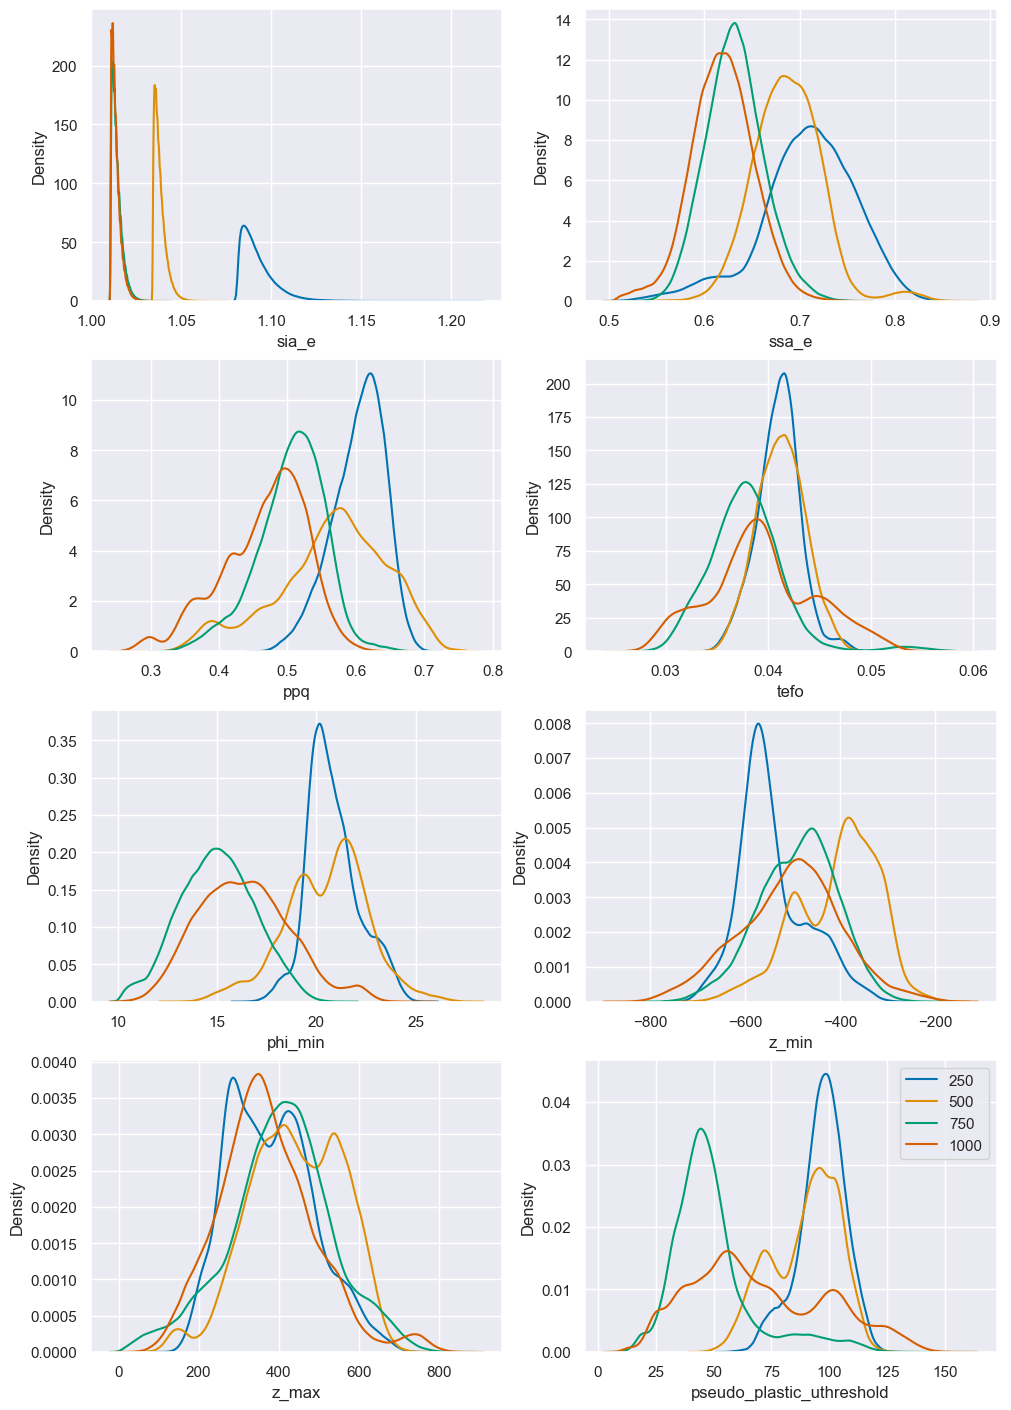

In [11]:
plot_posteriors(posterior_dfs, X_keys) 

In [49]:
np.mean(posterior_df[X_keys])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


sia_e                          1.013981
ssa_e                          0.619378
ppq                            0.466494
tefo                           0.039417
phi_min                       16.376969
z_min                       -504.901176
z_max                        369.577354
pseudo_plastic_uthreshold     69.789438
dtype: float64

In [5]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,200,40)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_divergences(posterior_df, X_keys, models, per_group=int(per_group),num_groups=20)

[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.
  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140.
 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200.]
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0


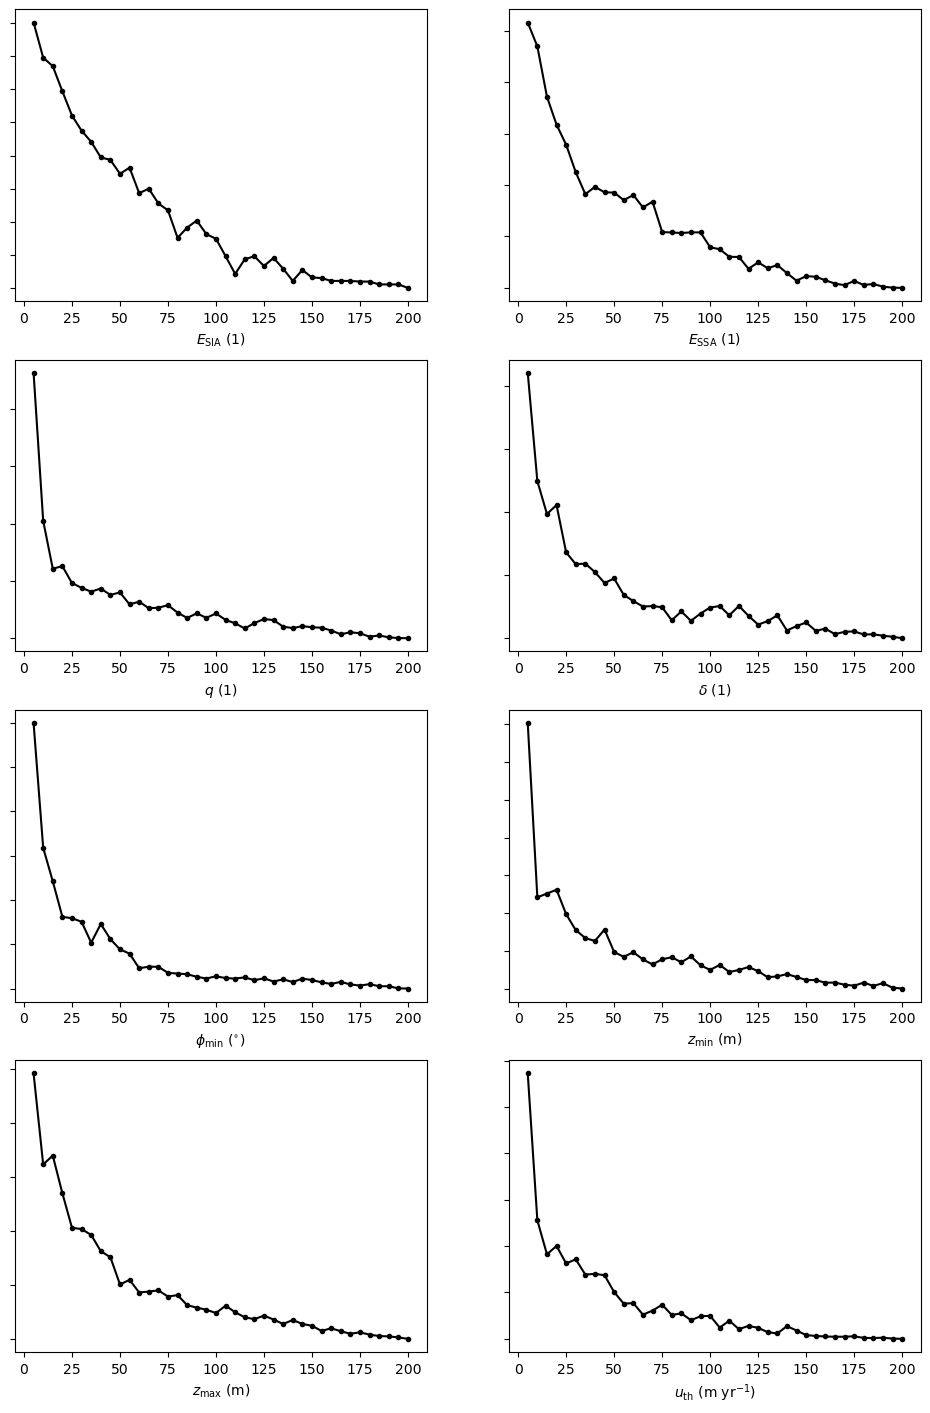

In [6]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)


In [9]:
#print(plot_groups(posterior_df, X_keys, models, per_group=15))
for pergroup in [15,50,100]:
    print(kl_divergences(posterior_df, X_keys, models, per_group=int(pergroup),num_groups=20)['ppq'])

6.064540099386894
3.9956136509606757
2.158208208016302


sia_e
ssa_e
ppq
tefo


KeyboardInterrupt: 

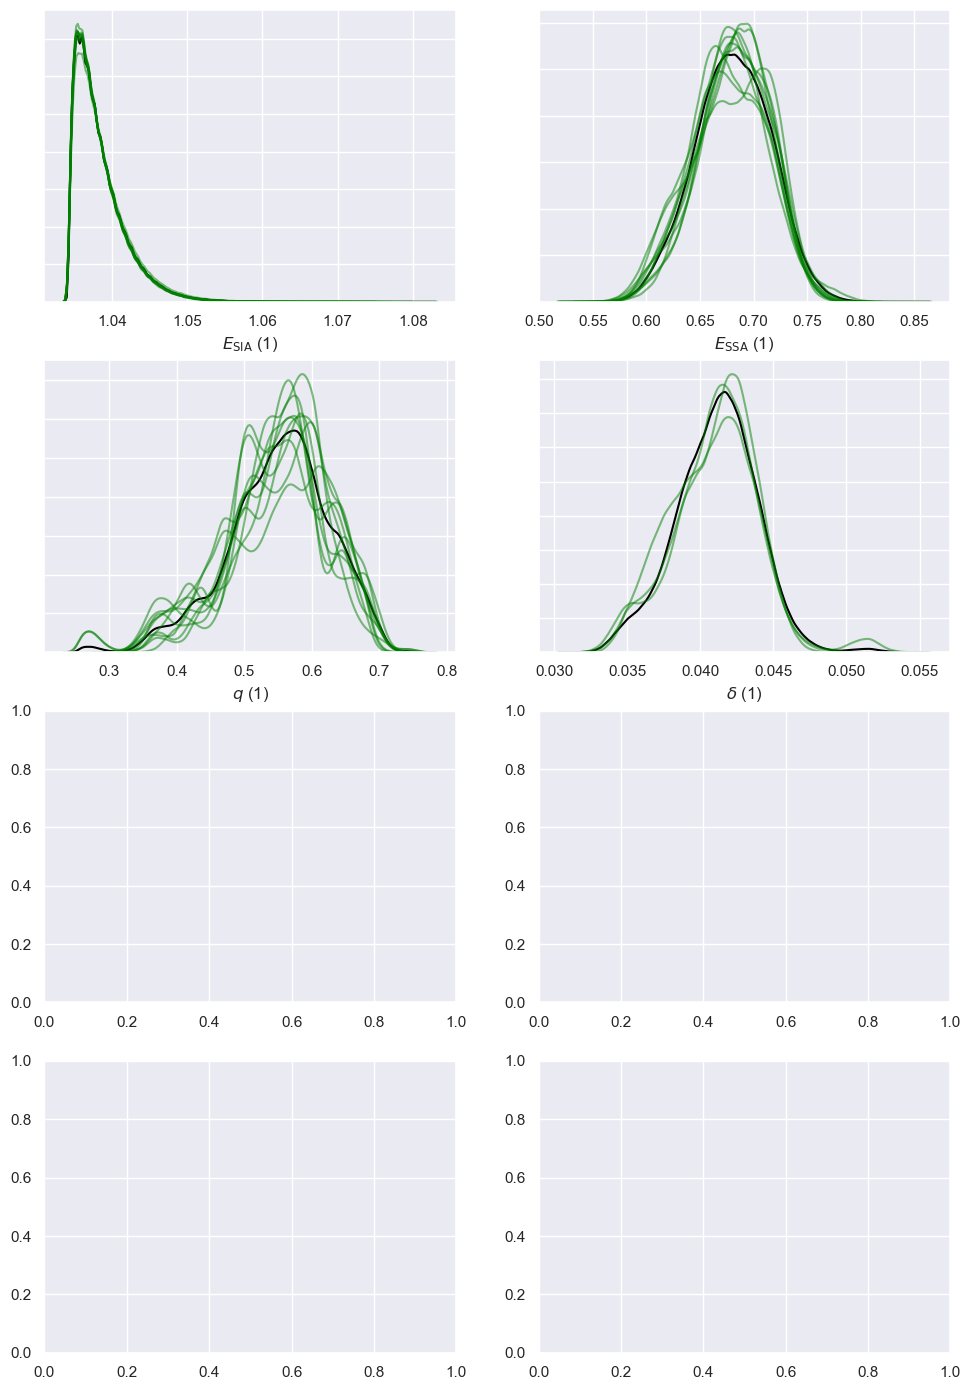

In [6]:
print(plot_groups(posterior_df, X_keys, models, per_group=50))

In [ ]:
print(plot_groups(posterior_df, X_keys, models, per_group=100))

sia_e
ssa_e
ppq
tefo
phi_min
z_min
z_max
pseudo_plastic_uthreshold


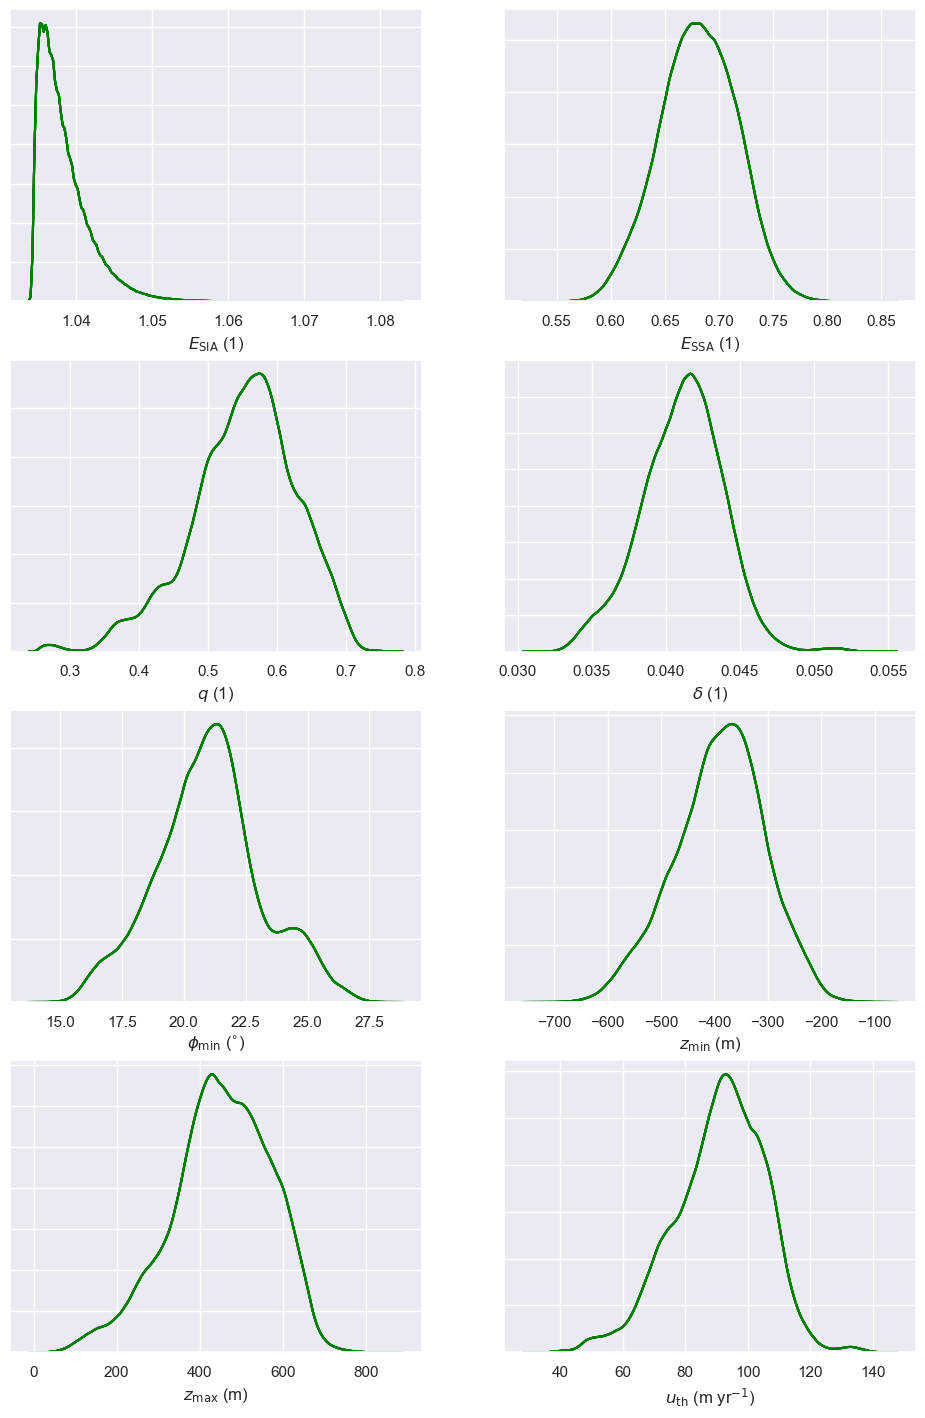

In [10]:
plot_groups(posterior_df, X_keys, models, per_group=200)

In [1]:
pairgrid = False
if pairgrid:
    g = sns.PairGrid(posterior_df, diag_sharey=False, corner=True,hue='Model')
    g.map_lower(sns.scatterplot,size=.1)
    g.map_diag(sns.kdeplot,alpha=0.3)

In [ ]:
grouped = posterior_df.groupby('Model')
grouped.first()